# IST 718
# Final Project Report
## Professor Lando
## Amanda Norwood

In [219]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [120]:
# Read in files
education = pd.read_csv('EducationalData.csv')
medianearnings = pd.read_csv('MedianEarningsbyIndustry.csv')
occupations = pd.read_csv('Occupations.csv')
homeprice = pd.read_excel('AvgHomePricebyZip.xlsx')
crime = pd.read_csv('crimes_with_zipcodes.csv')

In [121]:
crime.head()

,Unnamed: 0,DR_NO,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,...,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON,con_lat_lon,zipcode
0,0,10304468,1/8/2020 0:00,1/8/2020 0:00,2230,3,Southwest,377,2,624,...,624.0,NaN,NaN,NaN,1100 W 39TH PL,NaN,34.014,-118.298,"34.014,-118.298",90037
1,1,190101086,1/2/2020 0:00,1/1/2020 0:00,330,1,Central,163,2,624,...,624.0,NaN,NaN,NaN,700 S HILL ST,NaN,34.046,-118.254,"34.046,-118.254",90014
2,2,200110444,4/14/2020 0:00,2/13/2020 0:00,1200,1,Central,155,2,845,...,845.0,NaN,NaN,NaN,200 E 6TH ST,NaN,34.045,-118.247,"34.045,-118.247",90013
3,3,191501505,1/1/2020 0:00,1/1/2020 0:00,1730,15,N Hollywood,1543,2,745,...,745.0,998.0,NaN,NaN,5400 CORTEEN PL,NaN,34.168,-118.402,"34.168,-118.402",91607
4,4,191921269,1/1/2020 0:00,1/1/2020 0:00,415,19,Mission,1998,2,740,...,740.0,NaN,NaN,NaN,14400 TITUS ST,NaN,34.220,-118.447,"34.22,-118.447",91402


In [122]:
# clean education
education['Group'].unique()
#education[education['Group'] == 'Preschool']
education = education.drop(['ID Group','ID Year','ID State','State','Age Range'],axis=1)
education = education[~education['Group'].isin(['Preschool','Primary Education','Secondary Education'])]

In [123]:
education.head(5)

,ID Gender,Gender,Group,Year,Total Population,Total Population MOE Appx,Average Wage,Average Wage Appx MOE,Group ID,Percentage
0,2,Female,Associates Degree,2020,1161339,4012.757389,22279.847898,2835.671997,7,55.261437
1,2,Female,Bachelors Degree,2020,2994902,7539.885565,40526.050930,2986.719653,8,52.004361
2,2,Female,Graduate Degree,2020,1747439,3818.350081,46913.297071,6708.984104,9,50.422991
3,2,Female,High School or Equivalent,2020,2695919,6122.901609,17423.896492,2326.322214,5,49.180740
4,2,Female,No Schooling,2020,393477,1192.915610,8094.061415,7463.503355,1,53.622708


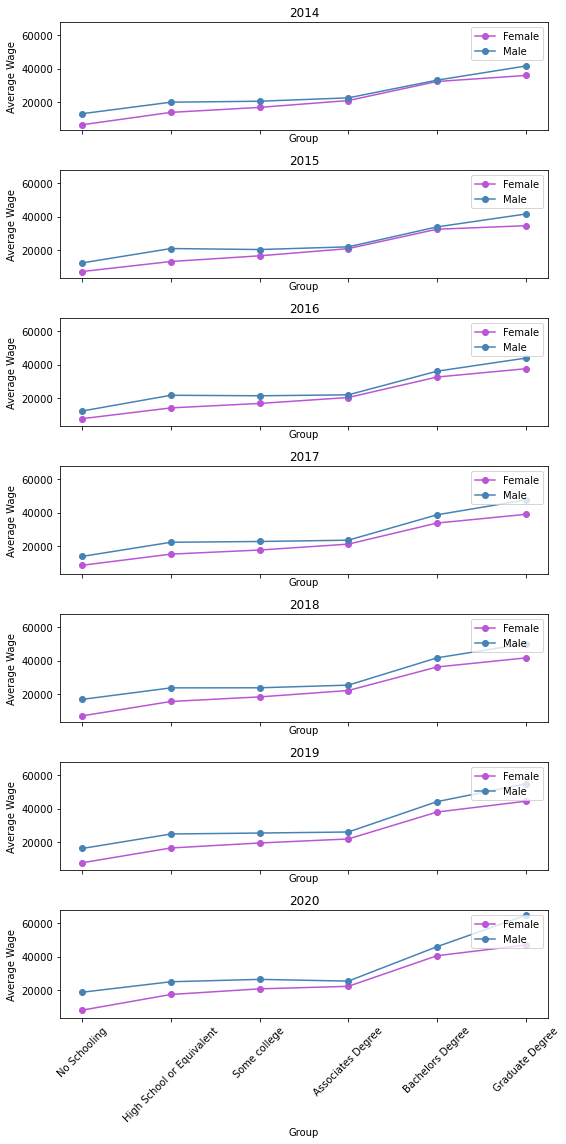

In [124]:
## Education/salary graph

df = education
years = sorted(df['Year'].unique())

# least to greatest
sorted_groups = df.groupby('Group')['Average Wage'].mean().sort_values().index

# subplot for each year
fig, axs = plt.subplots(len(years), figsize=(8, 16), sharex=True, sharey=True)
colors = ['mediumorchid', 'steelblue']

for i, year in enumerate(years):
    year_data = df[df['Year'] == year]

    groups = year_data['Group'].unique()
    x = range(len(groups))
    y_female = []
    y_male = []

    for group in sorted_groups:
        group_data = year_data[year_data['Group'] == group]
        female_wage = group_data[group_data['Gender'] == 'Female']['Average Wage']
        male_wage = group_data[group_data['Gender'] == 'Male']['Average Wage']
        y_female.append(female_wage.iloc[0] if len(female_wage) > 0 else 0)
        y_male.append(male_wage.iloc[0] if len(male_wage) > 0 else 0)

    axs[i].plot(x, y_female, marker='o', label='Female', color=colors[0])
    axs[i].plot(x, y_male, marker='o', label='Male', color=colors[1])
    axs[i].set_title(str(year))
    axs[i].set_xlabel('Group')
    axs[i].set_ylabel('Average Wage')

    axs[i].legend(['Female', 'Male'], loc='upper right')

    axs[i].set_xticks(range(len(groups)))
    axs[i].set_xticklabels(sorted_groups, rotation=45)

plt.tight_layout()
plt.show()


In [125]:
education.head()

education = education.drop(['ID Gender','Group ID'],axis=1)

In [126]:
## Linear Regression Model
## with t-test
data = education.copy()

features = ['Gender', 'Group', 'Average Wage']

# drop missing values
data = data.dropna(subset=features)

degree_types = data['Group'].unique()  # Define the degree types

grouped_data = data.groupby(['Gender', 'Group'])['Average Wage']
mean_salary = grouped_data.mean()

# repeat over each degree type
for degree_type in degree_types:
    print('Degree Type:', degree_type)
    print('-------------------------')

    degree_data = data[data['Group'] == degree_type]

    grouped_data = degree_data.groupby('Gender')['Average Wage']
    mean_salary = grouped_data.mean()
    gender_comparison = stats.ttest_ind(
        grouped_data.get_group('Female'), grouped_data.get_group('Male')
    )

    print('Mean Salary by Gender:')
    print(mean_salary)
    print('\nGender Comparison (T-test):')
    print(gender_comparison)
    print('-------------------------\n')

X = pd.get_dummies(data[['Gender', 'Group']])
y = data['Average Wage']

# split data (train/test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r_squared = model.score(X_test, y_test)

print('\nModel Evaluation:')
print('Mean Squared Error:', mse)
print('R-squared:', r_squared)

# coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})

# drop Gender_ and Group_
coefficients['Feature'] = coefficients['Feature'].str.replace('Gender_', '').str.replace('Group_', '')

print('\nModel Coefficients:')
print(coefficients)


Degree Type: Associates Degree
-------------------------
Mean Salary by Gender:
Gender
Female    21384.414883
Male      23822.578809
Name: Average Wage, dtype: float64

Gender Comparison (T-test):
Ttest_indResult(statistic=-3.377996679033909, pvalue=0.005488449053525724)
-------------------------

Degree Type: Bachelors Degree
-------------------------
Mean Salary by Gender:
Gender
Female    35094.598669
Male      39037.161290
Name: Average Wage, dtype: float64

Gender Comparison (T-test):
Ttest_indResult(statistic=-1.746972648298837, pvalue=0.10616067403281738)
-------------------------

Degree Type: Graduate Degree
-------------------------
Mean Salary by Gender:
Gender
Female    39954.886160
Male      49111.416991
Name: Average Wage, dtype: float64

Gender Comparison (T-test):
Ttest_indResult(statistic=-2.545162364074069, pvalue=0.025693269159943754)
-------------------------

Degree Type: High School or Equivalent
-------------------------
Mean Salary by Gender:
Gender
Female    15

In [127]:
## breakdown coeffcinets

coefficients_sorted = coefficients.set_index('Feature').loc[coefficients['Feature']].sort_values('Coefficient', ascending=True)
features_sorted = coefficients_sorted.index
coefficients_sorted = coefficients_sorted['Coefficient']

coefficients_sorted

Feature
No Schooling                -14524.976605
High School or Equivalent    -6537.676511
Some college                 -5415.060722
Associates Degree            -3876.491451
Female                       -3013.872550
Male                          3013.872550
Bachelors Degree             11639.872295
Graduate Degree              18714.332994
Name: Coefficient, dtype: float64

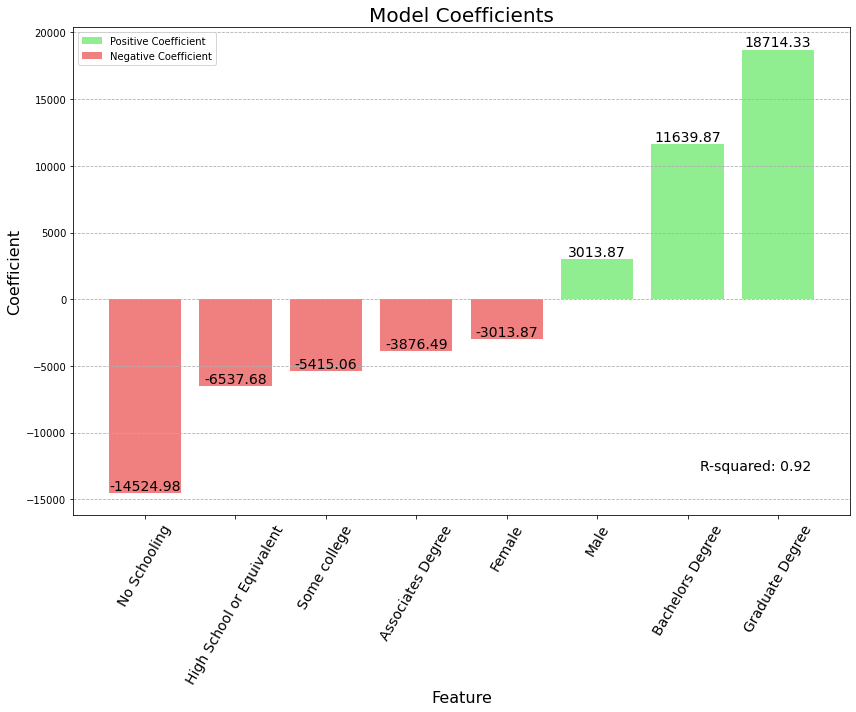

In [128]:
# plot the coefficients
colors_sorted = ['lightcoral' if coef < 0 else 'lightgreen' for coef in coefficients_sorted]

plt.figure(figsize=(12, 10))
bars = plt.bar(range(len(features_sorted)), coefficients_sorted, color=colors_sorted)
plt.xticks(range(len(features_sorted)), features_sorted, rotation=60, fontsize=14)  # Set x-axis tick positions and labels
plt.xlabel('Feature', fontsize=16)
plt.ylabel('Coefficient', fontsize=16)
plt.title('Model Coefficients', fontsize=20)
positive_bar = plt.bar(0, 0, color='lightgreen', label='Positive Coefficient')
negative_bar = plt.bar(0, 0, color='lightcoral', label='Negative Coefficient')
plt.legend(handles=[positive_bar, negative_bar])
plt.grid(axis='y', linestyle='--')

for i, bar in enumerate(bars):
    height = bar.get_height()
    coef = coefficients_sorted[i]
    feature = features_sorted[i]
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(coef, 2), ha='center', va='bottom', fontweight='light', fontsize=14)

#include r squared too
r_squared = model.score(X_test, y_test)
plt.text(0.95, 0.1, f'R-squared: {r_squared:.2f}', ha='right', va='center', transform=plt.gca().transAxes, fontsize=14)

plt.tight_layout()
plt.show()


Mean Salary by Gender and Education: group breakdown

Gender Comparision (T-Test): there is statistical significance between the average salaries between male and female. 
--> t-statistic value of -3.38: indicates difference in salary. t-test is used to measure the difference between sample means of two groups. 
--> p-value of 0.05: difference between genders is statistically significant

Model Evaluation: 
--> MSE: avg squared difference between the actual and predicted salaries. Maybe this is a little high?
--> R Sq: 0.92. model explains 92% of the variance in the average salary

Model Coefficients: 
--> Male/Female: the coefficients signify that males have higher salaries compared to women. 
--> Education groups: coefficients show the different education levels with 'No Schooling' as the most negative and 'Graduate Degree' as positive.

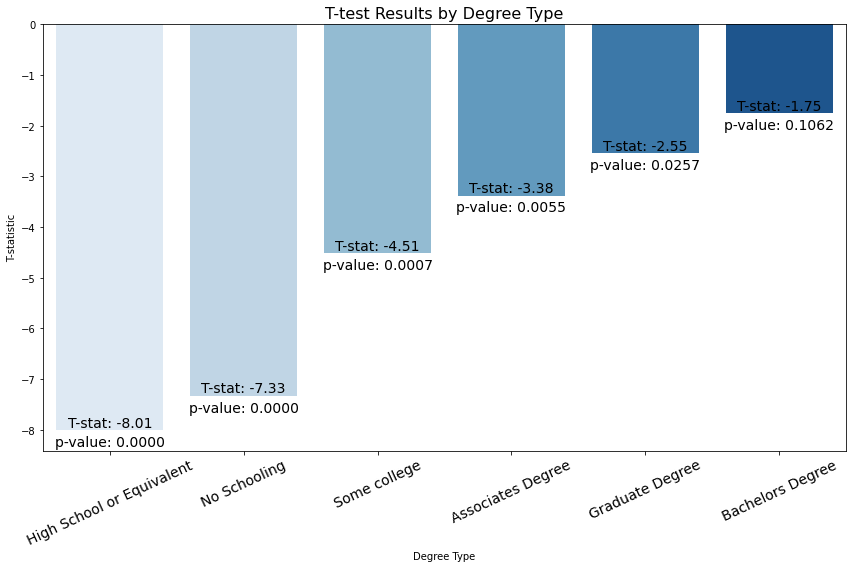

In [129]:
# using same data to graph the t-test results 
# and the salary comparison between genders by education
data = education.copy()
features = ['Gender', 'Group', 'Average Wage']

# drop missing values
data = data.dropna(subset=features)
degree_types = data['Group'].unique()
# gotta put results somewhere...
degree_type_labels = []
t_stats = []
p_values = []
average_salary_female = []
average_salary_male = []

# repeat over each degree type
for degree_type in degree_types:
    degree_data = data[data['Group'] == degree_type]
    
    grouped_data = degree_data.groupby('Gender')['Average Wage']
    
    groups = degree_data['Gender'].unique()
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            gender1 = groups[i]
            gender2 = groups[j]
            t_stat, p_value = stats.ttest_ind(grouped_data.get_group(gender1), grouped_data.get_group(gender2))
            
            degree_type_labels.append(degree_type)
            t_stats.append(t_stat)
            p_values.append(p_value)
            
            # Append average salary by gender to lists
            average_salary_female.append(grouped_data.get_group(gender1).mean())
            average_salary_male.append(grouped_data.get_group(gender2).mean())

results_df = pd.DataFrame({
    'Degree Type': degree_type_labels,
    'T-statistic': t_stats,
    'p-value': p_values,
    'Average Salary (Female)': average_salary_female,
    'Average Salary (Male)': average_salary_male
})

results_df = results_df.sort_values('T-statistic')

# Plotting the results
plt.figure(figsize=(12, 8))
sns.barplot(x='Degree Type', y='T-statistic', data=results_df, palette='Blues')
plt.ylabel('T-statistic')
plt.xticks(rotation=25, fontsize=14)
plt.xlabel('Degree Type')
plt.title('T-test Results by Degree Type', fontsize=16)

# Add p-value to the plot
for i, row in enumerate(results_df.iterrows()):
    plt.text(i, row[1]['T-statistic'], f'T-stat: {row[1]["T-statistic"]:.2f}', ha='center', va='bottom', fontsize=14)
    plt.text(i, row[1]['T-statistic'] - 0.1, f'p-value: {row[1]["p-value"]:.4f}', ha='center', va='top', fontsize=14)

plt.tight_layout()
plt.show()


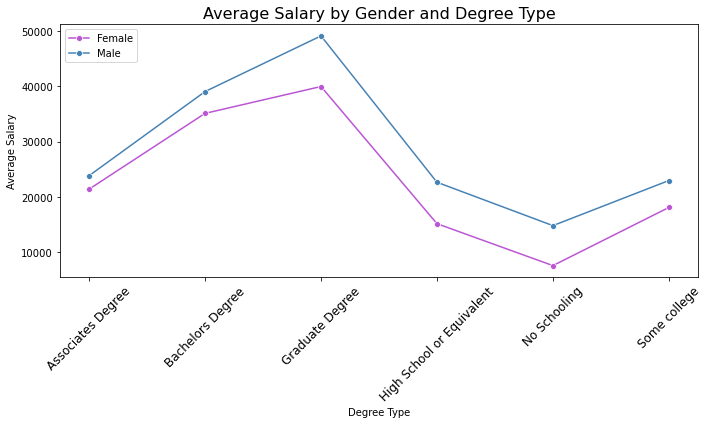

In [130]:

# avg salary by gender
plt.figure(figsize=(10, 6))
sns.lineplot(x=degree_type_labels, y=average_salary_female, marker='o', color='mediumorchid', label='Female')
sns.lineplot(x=degree_type_labels, y=average_salary_male, marker='o', color='steelblue', label='Male')
plt.ylabel('Average Salary')
plt.xticks(rotation=45,fontsize=12)
plt.xlabel('Degree Type')
plt.title('Average Salary by Gender and Degree Type',fontsize=16)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()



In [131]:
educationYOY = education[['Gender','Group','Year','Average Wage']]
educationpred = educationYOY.copy()

In [132]:
educationpred.head() 

,Gender,Group,Year,Average Wage
0,Female,Associates Degree,2020,22279.847898
1,Female,Bachelors Degree,2020,40526.050930
2,Female,Graduate Degree,2020,46913.297071
3,Female,High School or Equivalent,2020,17423.896492
4,Female,No Schooling,2020,8094.061415


In [133]:
educationpred

,Gender,Group,Year,Average Wage
0,Female,Associates Degree,2020,22279.847898
1,Female,Bachelors Degree,2020,40526.050930
2,Female,Graduate Degree,2020,46913.297071
3,Female,High School or Equivalent,2020,17423.896492
4,Female,No Schooling,2020,8094.061415
...,...,...,...,...
118,Male,Bachelors Degree,2014,33065.569399
119,Male,Graduate Degree,2014,41476.414373
120,Male,High School or Equivalent,2014,19938.661416
121,Male,No Schooling,2014,13090.641410


In [134]:
educationpred

,Gender,Group,Year,Average Wage
0,Female,Associates Degree,2020,22279.847898
1,Female,Bachelors Degree,2020,40526.050930
2,Female,Graduate Degree,2020,46913.297071
3,Female,High School or Equivalent,2020,17423.896492
4,Female,No Schooling,2020,8094.061415
...,...,...,...,...
118,Male,Bachelors Degree,2014,33065.569399
119,Male,Graduate Degree,2014,41476.414373
120,Male,High School or Equivalent,2014,19938.661416
121,Male,No Schooling,2014,13090.641410


In [135]:
# Linear Regression to predict incomes for 2021-2023

data = educationpred.copy()
features = ['Gender', 'Group', 'Year']
target = 'Average Wage'
numerical_features = []
categorical_features = []
for feature in features:
    if data[feature].dtype == 'object':
        categorical_features.append(feature)
    else:
        numerical_features.append(feature)
preprocessing = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# split the data into training and test
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('model', model)
])
# train the model
pipeline.fit(X_train, y_train)
# predict average wage
years = range(2021, 2024)
categories = data['Group'].unique()
genders = data['Gender'].unique()
predicted_data = []
for year in years:
    for category in categories:
        for gender in genders:
            new_data = pd.DataFrame({
                'Gender': [gender],
                'Group': [category],
                'Year': [year]
            })
            new_data_processed = pipeline.named_steps['preprocessing'].transform(new_data)

            predicted_wage = pipeline.named_steps['model'].predict(new_data_processed)[0]
            predicted_data.append({
                'Gender': gender,
                'Group': category,
                'Year': year,
                'Average Wage': predicted_wage
            })

predicted_df = pd.DataFrame(predicted_data)

# combine the predicted data to the original dataset
salaryprediction = pd.concat([data, predicted_df], ignore_index=True)
salaryprediction = salaryprediction.sort_values('Year')
salaryprediction

,Gender,Group,Year,Average Wage
83,Male,Some college,2014,20510.301437
82,Male,No Schooling,2014,13090.641410
81,Male,High School or Equivalent,2014,19938.661416
80,Male,Graduate Degree,2014,41476.414373
79,Male,Bachelors Degree,2014,33065.569399
...,...,...,...,...
109,Male,Associates Degree,2023,33720.204412
108,Female,Associates Degree,2023,27840.268767
118,Female,Some college,2023,25724.898144
112,Female,Graduate Degree,2023,49737.610074


In [136]:
salaryprediction['Year'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023])

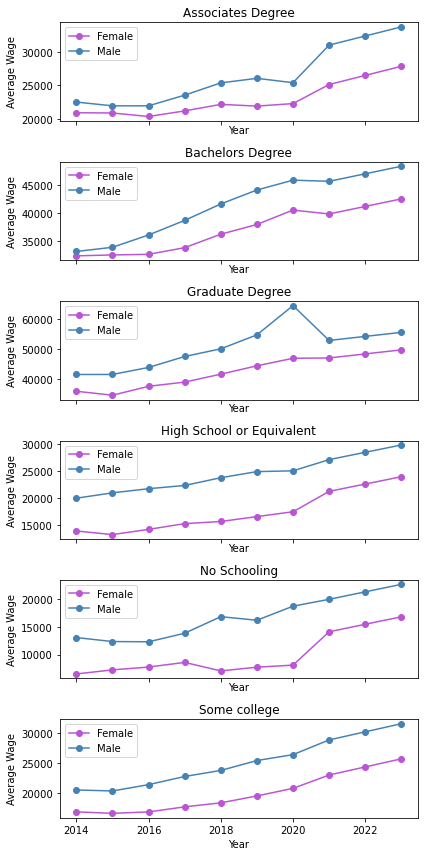

In [137]:
# graph the predicted salary

grouped_data = salaryprediction.groupby(['Year', 'Gender', 'Group']).mean().reset_index()

# subplot for each degree
groups = grouped_data['Group'].unique()
fig, axs = plt.subplots(len(groups), figsize=(6, 2 * len(groups)), sharex=True)

for i, group in enumerate(groups):
    group_data = grouped_data[grouped_data['Group'] == group]

    for gender in ['Female', 'Male']:
        gender_data = group_data[group_data['Gender'] == gender]
        years = gender_data['Year']
        wages = gender_data['Average Wage']
        
        color = 'mediumorchid' if gender == 'Female' else 'steelblue'  # Set color based on gender

        axs[i].plot(years, wages, marker='o', label=gender, color=color)

    axs[i].set_title(group)
    axs[i].set_xlabel('Year')
    axs[i].set_ylabel('Average Wage')
    axs[i].legend()

plt.tight_layout()
plt.show()


In [138]:
# prep to graph YOY change
educationYOY = salaryprediction[['Gender','Group','Year','Average Wage']]

df = educationYOY
df['Year'] = pd.to_datetime(df['Year'], format='%Y')
df.sort_values(['Year', 'Group'], inplace=True)

# calculate YOY change
df['YOY Change'] = df.groupby(['Gender', 'Group'])['Average Wage'].pct_change()
# drop na values since the first year will be null
df.dropna(subset=['YOY Change'], inplace=True)
df.head(1)

,Gender,Group,Year,Average Wage,YOY Change
72,Male,Associates Degree,2015-01-01,21945.152606,-0.025178


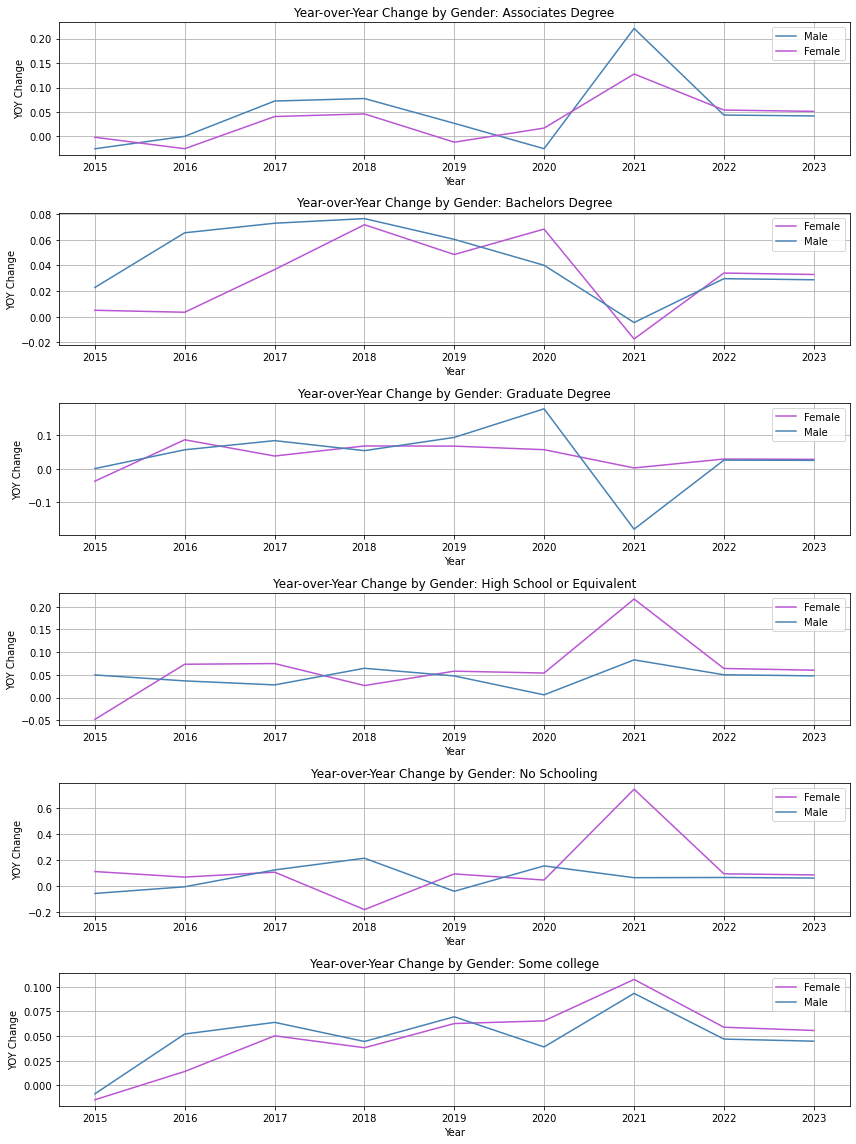

In [227]:
# showing the YOY change
groups = df['Group'].unique()
group_data = {}

for group in groups:
    group_data[group] = df[df['Group'] == group]

# Define colors for female and male
colors = {'Female': 'mediumorchid', 'Male': 'steelblue'}

# Plotting
fig, axs = plt.subplots(len(groups), figsize=(12, 16))

for i, group in enumerate(groups):
    data = group_data[group]
    ax = axs[i]
    genders = data['Gender'].unique()

    for gender in genders:
        gender_data = data[data['Gender'] == gender]
        color = colors[gender]  # Get the color based on gender
        ax.plot(gender_data['Year'], gender_data['YOY Change'], label=gender, color=color)

    ax.set_xlabel('Year')
    ax.set_ylabel('YOY Change')
    ax.set_title(f'Year-over-Year Change by Gender: {group}')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [140]:
education['Year'].unique()

array([2020, 2019, 2018, 2017, 2016, 2015, 2014])

In [141]:
medianearnings.head()

medianearnings = medianearnings.drop(['ID Year','ID Geography','Geography','Slug Geography'],axis=1)


In [142]:
medianearnings.head()

,ID Gender,Gender,ID Industry Group,Industry Group,Year,Median Earnings by Industry and Gender,Median Earnings by Industry and Gender Moe
0,0,Male,1,"Agriculture, Forestry, Fishing & Hunting, & Mi...",2020,27462,5706
1,0,Male,2,Construction,2020,31123,358
2,0,Male,3,Manufacturing,2020,39168,1360
3,0,Male,4,Wholesale Trade,2020,40638,1416
4,0,Male,5,Retail Trade,2020,28440,991


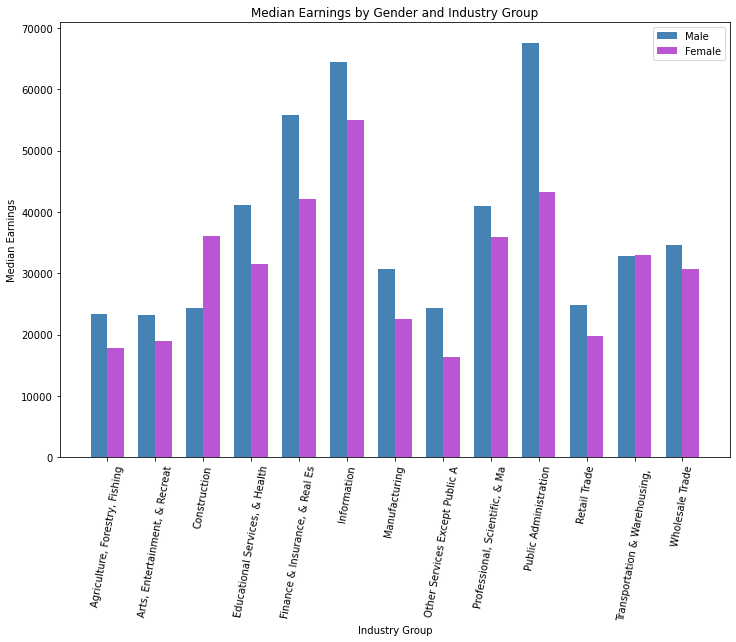

In [143]:
# median earnings
grouped_df = medianearnings.groupby(['Gender', 'Industry Group'])['Median Earnings by Industry and Gender'].median().reset_index()

industry_groups = grouped_df['Industry Group'].unique()
# width
bar_width = 0.35

# positions for the bars
male_positions = np.arange(len(industry_groups))
female_positions = male_positions + bar_width

plt.figure(figsize=(12, 8))
# Subset male/female
male_data = grouped_df[grouped_df['Gender'] == 'Male']
female_data = grouped_df[grouped_df['Gender'] == 'Female']

# plot the median earnings for males & females
plt.bar(male_positions, male_data['Median Earnings by Industry and Gender'], width=bar_width, label='Male', color='steelblue')
plt.bar(female_positions, female_data['Median Earnings by Industry and Gender'], width=bar_width, label='Female', color='mediumorchid')

plt.xticks(male_positions + bar_width / 2, [label[:30] for label in industry_groups], rotation=80)
plt.xlabel('Industry Group')
plt.ylabel('Median Earnings')
plt.title('Median Earnings by Gender and Industry Group')
plt.legend()

plt.show()


In [144]:
list(industry_groups)

['Agriculture, Forestry, Fishing & Hunting, & Mining',
 'Arts, Entertainment, & Recreation, & Accommodations & Food Services',
 'Construction',
 'Educational Services, & Health Care & Social Assistance',
 'Finance & Insurance, & Real Estate & Rental & Leasing',
 'Information',
 'Manufacturing',
 'Other Services Except Public Administration',
 'Professional, Scientific, & Management, & Administrative & Waste Management Services',
 'Public Administration',
 'Retail Trade',
 'Transportation & Warehousing, & Utilities',
 'Wholesale Trade']

In [145]:
occupations['Year'].unique()

array([2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013])

In [146]:
occupations.head()
occupations = occupations.drop(['ID Year','ID State','State','ID Geography','Geography','Slug Geography'],axis=1)

In [147]:
occupations.head()

,ID Group,Group,ID Subgroup,Subgroup,ID Occupation,Occupation,Year,Workforce by Occupation and Gender,Workforce by Occupation and Gender Moe,ACS Occupation yg RCA,Median Earnings,Median Earnings Moe,Workforce Prev,Workforce Growth,Median Earnings Prev,Median Earnings Growth,Share
0,0,"Management, Business, Science, & Arts Occupations",0,"Management, Business, & Financial Occupations",0,Management Occupations,2020,201655,3336.835926,0.952741,147944,2912,193588.0,4.167097,141961.0,4.214538,10.007086
1,0,"Management, Business, Science, & Arts Occupations",0,"Management, Business, & Financial Occupations",1,Business & Financial Operations Occupations,2020,108938,2778.260067,0.978913,136895,4037,106250.0,2.529882,132912.0,2.996720,5.406025
2,0,"Management, Business, Science, & Arts Occupations",1,"Computer, Engineering, & Science Occupations",2,Computer & Mathematical Occupations,2020,50906,1768.765106,0.776306,151426,5916,48483.0,4.997628,147857.0,2.413819,2.526199
3,0,"Management, Business, Science, & Arts Occupations",1,"Computer, Engineering, & Science Occupations",3,Architecture & Engineering Occupations,2020,28250,1365.376505,0.707571,161213,10847,26106.0,8.212671,153655.0,4.918812,1.401900
4,0,"Management, Business, Science, & Arts Occupations",1,"Computer, Engineering, & Science Occupations",4,"Life, Physical, & Social Science Occupations",2020,17003,1014.070017,0.849085,123577,9166,16358.0,3.943025,117627.0,5.058362,0.843770


In [149]:
homeprice = homeprice.rename(columns={'2023*': 2023})
homeprice.describe()

,Zip Code,2023,2022,2021,2020,2019,2018
count,275.000000,2.680000e+02,2.740000e+02,2.750000e+02,2.750000e+02,2.750000e+02,2.750000e+02
mean,90911.978182,1.116389e+06,1.150845e+06,1.085190e+06,9.744483e+05,8.990159e+05,8.987289e+05
std,844.428887,6.975024e+05,7.203652e+05,6.773029e+05,5.983871e+05,5.636030e+05,5.717003e+05
min,90001.000000,3.536390e+05,3.665310e+05,3.444270e+05,2.894420e+05,2.634590e+05,2.479250e+05
25%,90226.000000,7.195190e+05,7.421698e+05,7.016110e+05,6.375905e+05,5.847410e+05,5.773955e+05
50%,90746.000000,8.747265e+05,9.019995e+05,8.527020e+05,7.744530e+05,7.120740e+05,7.099720e+05
75%,91374.000000,1.286105e+06,1.324968e+06,1.242047e+06,1.114240e+06,1.018949e+06,1.012279e+06
max,93591.000000,5.867635e+06,5.947918e+06,5.565130e+06,4.814363e+06,4.501657e+06,4.073760e+06


In [150]:
crime.head()
crime = crime.drop(['DR_NO','AREA','Premis Cd','Weapon Used Cd','Rpt Dist No','Part 1-2','Crm Cd','Status','Mocodes','Crm Cd 1','Crm Cd 2','Crm Cd 3','Crm Cd 4','Cross Street'],axis=1)

In [151]:
crime.head()

,Unnamed: 0,Date Rptd,DATE OCC,TIME OCC,AREA NAME,Crm Cd Desc,Vict Age,Vict Sex,Vict Descent,Premis Desc,Weapon Desc,Status Desc,LOCATION,LAT,LON,con_lat_lon,zipcode
0,0,1/8/2020 0:00,1/8/2020 0:00,2230,Southwest,BATTERY - SIMPLE ASSAULT,36,F,B,SINGLE FAMILY DWELLING,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,1100 W 39TH PL,34.014,-118.298,"34.014,-118.298",90037
1,1,1/2/2020 0:00,1/1/2020 0:00,330,Central,BATTERY - SIMPLE ASSAULT,25,M,H,SIDEWALK,UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,700 S HILL ST,34.046,-118.254,"34.046,-118.254",90014
2,2,4/14/2020 0:00,2/13/2020 0:00,1200,Central,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,0,X,X,POLICE FACILITY,NaN,Adult Arrest,200 E 6TH ST,34.045,-118.247,"34.045,-118.247",90013
3,3,1/1/2020 0:00,1/1/2020 0:00,1730,N Hollywood,VANDALISM - MISDEAMEANOR ($399 OR UNDER),76,F,W,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Invest Cont,5400 CORTEEN PL,34.168,-118.402,"34.168,-118.402",91607
4,4,1/1/2020 0:00,1/1/2020 0:00,415,Mission,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",31,X,X,BEAUTY SUPPLY STORE,NaN,Invest Cont,14400 TITUS ST,34.220,-118.447,"34.22,-118.447",91402


In [152]:
crime['Weapon Desc'].unique()

array(['STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)',
       'UNKNOWN WEAPON/OTHER WEAPON', nan, 'ROCK/THROWN OBJECT',
       'VERBAL THREAT', 'FOLDING KNIFE', 'BLUNT INSTRUMENT', 'BOTTLE',
       'SEMI-AUTOMATIC PISTOL', 'CLUB/BAT', 'OTHER CUTTING INSTRUMENT',
       'HAND GUN', 'PHYSICAL PRESENCE', 'VEHICLE', 'SCISSORS', 'STICK',
       'MACHETE', 'OTHER KNIFE', 'SHOTGUN', 'ICE PICK',
       'KNIFE WITH BLADE 6INCHES OR LESS', 'FIRE', 'GLASS',
       'SIMULATED GUN', 'KNIFE WITH BLADE OVER 6 INCHES IN LENGTH',
       'DEMAND NOTE', 'BOMB THREAT', 'PIPE/METAL PIPE', 'UNKNOWN FIREARM',
       'MACE/PEPPER SPRAY', 'HAMMER', 'RAZOR', 'OTHER FIREARM',
       'BELT FLAILING INSTRUMENT/CHAIN',
       'UNKNOWN TYPE CUTTING INSTRUMENT', 'SCREWDRIVER', 'KITCHEN KNIFE',
       'AIR PISTOL/REVOLVER/RIFLE/BB GUN', 'BRASS KNUCKLES', 'REVOLVER',
       'SWITCH BLADE', 'STUN GUN', 'AXE', 'RIFLE',
       'ASSAULT WEAPON/UZI/AK47/ETC', 'ANTIQUE FIREARM', 'FIXED OBJECT',
       'SEMI-AUTOMATIC RIFLE

In [153]:
crime['zipcode'].unique()

array(['90037', '90014', '90013', '91607', '91402', '90017', '90012',
       '91342', '90015', '91340', '90851', '90710', '91411', '91405',
       '91316', '91356', '90027', '90086', '90049', '90071', '90035',
       '90048', '91401', '90074', '90025', '90292', '90057', '90044',
       '90031', '90033', '90227', '90034', '90021', '90016', '90003',
       '90028', '90066', '90007', '90036', '90062', '90731', '90079',
       '90002', '91352', '90212', '90210', '91406', '90042', '90043',
       '90029', '90059', '90272', '90032', '90732', '90064', '90019',
       '91335', '90004', '90026', '90006', '90038', '91306', '90024',
       '90744', '90039', '91324', '91344', '90005', '90023', '90001',
       '90291', '90046', '91605', '90008', '90011', '91403', '90041',
       '90230', '91436', '90501', '91343', '91423', '90018', '90068',
       '90065', '90020', '90063', '91328', '90010', '91331', '90248',
       '90047', '90077', '90067', '91606', '91601', '91303', '90094',
       '90045', '902

In [154]:
crime.dtypes
# Drop California
crime = crime.drop(crime[crime['zipcode'] == 'California'].index)
crime = crime.drop(crime[crime['zipcode'] == '90272-3002'].index)
crime['zipcode'] = crime['zipcode'].astype(int)

In [155]:
crime['Weapon Desc'].unique()

array(['STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)',
       'UNKNOWN WEAPON/OTHER WEAPON', nan, 'ROCK/THROWN OBJECT',
       'VERBAL THREAT', 'FOLDING KNIFE', 'BLUNT INSTRUMENT', 'BOTTLE',
       'SEMI-AUTOMATIC PISTOL', 'CLUB/BAT', 'OTHER CUTTING INSTRUMENT',
       'HAND GUN', 'PHYSICAL PRESENCE', 'VEHICLE', 'SCISSORS', 'STICK',
       'MACHETE', 'OTHER KNIFE', 'SHOTGUN', 'ICE PICK',
       'KNIFE WITH BLADE 6INCHES OR LESS', 'FIRE', 'GLASS',
       'SIMULATED GUN', 'KNIFE WITH BLADE OVER 6 INCHES IN LENGTH',
       'DEMAND NOTE', 'BOMB THREAT', 'PIPE/METAL PIPE', 'UNKNOWN FIREARM',
       'MACE/PEPPER SPRAY', 'HAMMER', 'RAZOR', 'OTHER FIREARM',
       'BELT FLAILING INSTRUMENT/CHAIN',
       'UNKNOWN TYPE CUTTING INSTRUMENT', 'SCREWDRIVER', 'KITCHEN KNIFE',
       'AIR PISTOL/REVOLVER/RIFLE/BB GUN', 'BRASS KNUCKLES', 'REVOLVER',
       'SWITCH BLADE', 'STUN GUN', 'AXE', 'RIFLE',
       'ASSAULT WEAPON/UZI/AK47/ETC', 'ANTIQUE FIREARM', 'FIXED OBJECT',
       'SEMI-AUTOMATIC RIFLE

In [156]:
# Create binary 'weapon' column
crime['weapon'] = crime['Weapon Desc'].notnull().astype(int)

crime['weapon'].fillna(0, inplace=True)

In [157]:
crime[['weapon','zipcode']].head()

,weapon,zipcode
0,1,90037
1,1,90014
2,0,90013
3,0,91607
4,0,91402


In [173]:
# count of total number of rows and number of 1's (yes, weapons)

weaponcount = crime.groupby('zipcode')['weapon'].agg(['sum', 'size'])

weaponcount.columns = ['Total_Weapons', 'Total_Crimes']

weaponcount['WeaponRatio'] = round(weaponcount['Total_Weapons']/ weaponcount['Total_Crimes'],2)

weaponcount

,Total_Weapons,Total_Crimes,WeaponRatio
zipcode,,,
13359,126,666,0.19
60031,38,127,0.30
90001,1297,2740,0.47
90002,3918,8247,0.48
90003,8551,16562,0.52
...,...,...,...
91605,2508,7905,0.32
91606,2187,7083,0.31
91607,850,4120,0.21


In [174]:
weaponcount = weaponcount.reset_index()

In [175]:
weaponcount.sort_values(by='WeaponRatio',ascending=True)

,zipcode,Total_Weapons,Total_Crimes,WeaponRatio
135,91302,0,1,0.00
104,90403,0,8,0.00
87,90260,0,1,0.00
69,90081,0,2,0.00
91,90278,2,22,0.09
...,...,...,...,...
127,91108,11,19,0.58
88,90265,3,5,0.60
182,91803,3,4,0.75
92,90280,7,8,0.88


In [176]:
test = weaponcount['Total_Crimes'].sum()
test2 = weaponcount['Total_Weapons'].sum()
weaponcount['CrimeRelFreq'] = round(weaponcount['Total_Crimes'] / test,3)
weaponcount['WeaponRelFreq'] = round(weaponcount['Total_Weapons'] / test2,3)

In [177]:
weaponcount['WeaponRatio'] = round(weaponcount['WeaponRatio'] * 100, 2)
weaponcount['CrimeRelFreq'] = round(weaponcount['CrimeRelFreq'] * 100, 2)
weaponcount['WeaponRelFreq'] = round(weaponcount['WeaponRelFreq'] * 100, 2)

In [178]:
weaponcount.sort_values(by='WeaponRelFreq',ascending=False)

,zipcode,Total_Weapons,Total_Crimes,WeaponRatio,CrimeRelFreq,WeaponRelFreq
43,90044,9276,18779,49.0,2.6,3.8
4,90003,8551,16562,52.0,2.3,3.5
28,90028,7630,17553,43.0,2.5,3.1
36,90037,6316,13344,47.0,1.9,2.6
12,90011,6304,14519,43.0,2.0,2.6
...,...,...,...,...,...,...
112,90717,91,283,32.0,0.0,0.0
109,90504,19,59,32.0,0.0,0.0
106,90405,30,133,23.0,0.0,0.0
105,90404,28,102,27.0,0.0,0.0


In [185]:
homeclean = homeprice.merge(weaponcount, left_on='Zip Code',right_on='zipcode')
homeclean = homeclean.drop('zipcode', axis=1)
homeclean.head()

,Zip Code,City / Community,2023,2022,2021,2020,2019,2018,Total_Weapons,Total_Crimes,WeaponRatio,CrimeRelFreq,WeaponRelFreq
0,90001,"Los Angeles (South Los Angeles), Florence-Graham",540635.0,555034.0,508199,465268,425927,404863,1297,2740,47.0,0.4,0.5
1,90002,"Los Angeles (Southeast Los Angeles, Watts)",539102.0,552950.0,518364,463726,421153,398477,3918,8247,48.0,1.2,1.6
2,90003,"Los Angeles (South Los Angeles, Southeast Los ...",558141.0,577163.0,542654,480137,435456,413903,8551,16562,52.0,2.3,3.5
3,90004,"Los Angeles (Hancock Park, Rampart Village, Vi...",1767062.0,1824797.0,1722525,1578331,1453209,1477493,3235,9511,34.0,1.3,1.3
4,90005,"Los Angeles (Hancock Park, Koreatown, Wilshire...",1791046.0,1880689.0,1774383,1602551,1487273,1504952,2492,6627,38.0,0.9,1.0


Text(0.5, 1.0, 'Correlation Matrix')

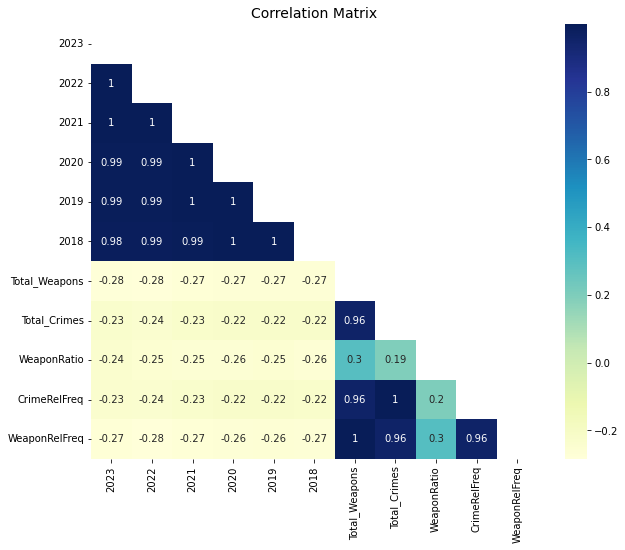

In [186]:
corr = homeclean.copy()
corr.drop('Zip Code', axis=1, inplace=True)

corr = corr.corr()

plt.figure(figsize=(10,8))

mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask = mask,annot=True,cmap='YlGnBu')
plt.title('Correlation Matrix',fontsize=14)


In [187]:
occupations.head()

,ID Group,Group,ID Subgroup,Subgroup,ID Occupation,Occupation,Year,Workforce by Occupation and Gender,Workforce by Occupation and Gender Moe,ACS Occupation yg RCA,Median Earnings,Median Earnings Moe,Workforce Prev,Workforce Growth,Median Earnings Prev,Median Earnings Growth,Share
0,0,"Management, Business, Science, & Arts Occupations",0,"Management, Business, & Financial Occupations",0,Management Occupations,2020,201655,3336.835926,0.952741,147944,2912,193588.0,4.167097,141961.0,4.214538,10.007086
1,0,"Management, Business, Science, & Arts Occupations",0,"Management, Business, & Financial Occupations",1,Business & Financial Operations Occupations,2020,108938,2778.260067,0.978913,136895,4037,106250.0,2.529882,132912.0,2.996720,5.406025
2,0,"Management, Business, Science, & Arts Occupations",1,"Computer, Engineering, & Science Occupations",2,Computer & Mathematical Occupations,2020,50906,1768.765106,0.776306,151426,5916,48483.0,4.997628,147857.0,2.413819,2.526199
3,0,"Management, Business, Science, & Arts Occupations",1,"Computer, Engineering, & Science Occupations",3,Architecture & Engineering Occupations,2020,28250,1365.376505,0.707571,161213,10847,26106.0,8.212671,153655.0,4.918812,1.401900
4,0,"Management, Business, Science, & Arts Occupations",1,"Computer, Engineering, & Science Occupations",4,"Life, Physical, & Social Science Occupations",2020,17003,1014.070017,0.849085,123577,9166,16358.0,3.943025,117627.0,5.058362,0.843770


In [188]:
occup = occupations[['Year','Occupation','Median Earnings']]
occup = occup.loc[occup['Year'] == 2020] 
#occup = occup.groupby(['Year','Occupation'])['Median Earnings'].mean()

In [189]:
occup = pd.DataFrame(data=occup)
occup['Occupation'] = occup['Occupation'].str.replace(' Occupations', '')


In [190]:
medianearnings.head(3)

,ID Gender,Gender,ID Industry Group,Industry Group,Year,Median Earnings by Industry and Gender,Median Earnings by Industry and Gender Moe
0,0,Male,1,"Agriculture, Forestry, Fishing & Hunting, & Mi...",2020,27462,5706
1,0,Male,2,Construction,2020,31123,358
2,0,Male,3,Manufacturing,2020,39168,1360


In [191]:
data_2020 = medianearnings[medianearnings['Year'] == 2020]

average_salary_by_group = data_2020.groupby('Industry Group')['Median Earnings by Industry and Gender'].mean()

avg_sal = pd.DataFrame(average_salary_by_group)
average_salary_by_group

Industry Group
Agriculture, Forestry, Fishing & Hunting, & Mining                                      24075.0
Arts, Entertainment, & Recreation, & Accommodations & Food Services                     24684.0
Construction                                                                            36365.5
Educational Services, & Health Care & Social Assistance                                 41376.0
Finance & Insurance, & Real Estate & Rental & Leasing                                   58793.5
Information                                                                             69996.0
Manufacturing                                                                           34134.5
Other Services Except Public Administration                                             25240.0
Professional, Scientific, & Management, & Administrative & Waste Management Services    47194.5
Public Administration                                                                   58136.0
Retail Trade             

In [192]:
average_salary_data = pd.DataFrame({
    'Year': ['2020'] * len(average_salary_by_group),  # Repeat '2020' for the length of the average salary data
    'Occupation': average_salary_by_group.index,
    'Median Earnings': average_salary_by_group.values
})
average_salary_data

,Year,Occupation,Median Earnings
0,2020,"Agriculture, Forestry, Fishing & Hunting, & Mi...",24075.0
1,2020,"Arts, Entertainment, & Recreation, & Accommoda...",24684.0
2,2020,Construction,36365.5
3,2020,"Educational Services, & Health Care & Social A...",41376.0
4,2020,"Finance & Insurance, & Real Estate & Rental & ...",58793.5
5,2020,Information,69996.0
6,2020,Manufacturing,34134.5
7,2020,Other Services Except Public Administration,25240.0
8,2020,"Professional, Scientific, & Management, & Admi...",47194.5
9,2020,Public Administration,58136.0


In [193]:
combined_data = pd.concat([average_salary_data, occup], ignore_index=True)
combined_data

,Year,Occupation,Median Earnings
0,2020,"Agriculture, Forestry, Fishing & Hunting, & Mi...",24075.0
1,2020,"Arts, Entertainment, & Recreation, & Accommoda...",24684.0
2,2020,Construction,36365.5
3,2020,"Educational Services, & Health Care & Social A...",41376.0
4,2020,"Finance & Insurance, & Real Estate & Rental & ...",58793.5
5,2020,Information,69996.0
6,2020,Manufacturing,34134.5
7,2020,Other Services Except Public Administration,25240.0
8,2020,"Professional, Scientific, & Management, & Admi...",47194.5
9,2020,Public Administration,58136.0


In [194]:
sorteddata = combined_data.sort_values(by='Median Earnings', ascending=False)
sorteddata

,Year,Occupation,Median Earnings
19,2020,Legal,215184.0
22,2020,Health Diagnosing & Treating Practitioners & O...,180900.0
16,2020,Architecture & Engineering,161213.0
15,2020,Computer & Mathematical,151426.0
29,2020,Law Enforcement Workers Including Supervisors,151404.0
13,2020,Management,147944.0
14,2020,Business & Financial Operations,136895.0
17,2020,"Life, Physical, & Social Science",123577.0
21,2020,"Arts, Design, Entertainment, Sports, & Media",114414.0
23,2020,Health Technologists & Technicians,90323.0


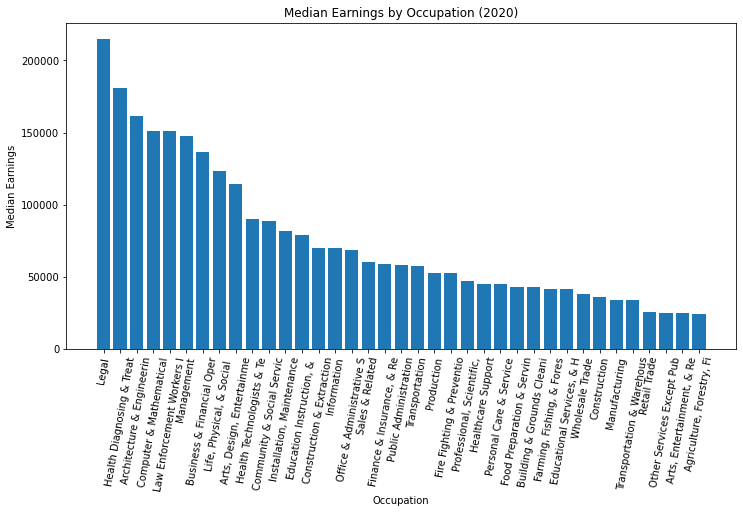

In [211]:
sorteddata = combined_data.sort_values(by='Median Earnings', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(sorteddata['Occupation'], sorteddata['Median Earnings'])
plt.xticks(rotation=80)
plt.xticks(range(len(sorteddata['Occupation'])), [label[:25] for label in sorteddata['Occupation']])
plt.xlabel('Occupation')
plt.ylabel('Median Earnings')
plt.title('Median Earnings by Occupation (2020)')
plt.show()



In [196]:
occup['3x'] = occup['Median Earnings'] * 3
occup['4x'] = occup['Median Earnings'] * 4
occup['5x'] = occup['Median Earnings'] * 5

In [197]:
occup.sort_values(by='Median Earnings') 

,Year,Occupation,Median Earnings,3x,4x,5x
19,2020,"Farming, Fishing, & Forestry",41622,124866,166488,208110
13,2020,Building & Grounds Cleaning & Maintenance,42718,128154,170872,213590
12,2020,Food Preparation & Serving Related,42938,128814,171752,214690
14,2020,Personal Care & Service,45091,135273,180364,225455
11,2020,Healthcare Support,45194,135582,180776,225970
15,2020,"Fire Fighting & Prevention, & Other Protective...",52540,157620,210160,262700
22,2020,Production,52665,157995,210660,263325
23,2020,Transportation,57396,172188,229584,286980
17,2020,Sales & Related,60297,180891,241188,301485
18,2020,Office & Administrative Support,68740,206220,274960,343700


In [198]:
homeclean.sort_values(by=2020)

,Zip Code,City / Community,2023,2022,2021,2020,2019,2018,Total_Weapons,Total_Crimes,WeaponRatio,CrimeRelFreq,WeaponRelFreq
1,90002,"Los Angeles (Southeast Los Angeles, Watts)",539102.0,552950.0,518364,463726,421153,398477,3918,8247,48.0,1.2,1.6
0,90001,"Los Angeles (South Los Angeles), Florence-Graham",540635.0,555034.0,508199,465268,425927,404863,1297,2740,47.0,0.4,0.5
49,90059,"Los Angeles (Southeast Los Angeles, Watts), Wi...",548066.0,563478.0,528218,471088,427050,402926,3123,6191,50.0,0.9,1.3
2,90003,"Los Angeles (South Los Angeles, Southeast Los ...",558141.0,577163.0,542654,480137,435456,413903,8551,16562,52.0,2.3,3.5
48,90058,"Los Angeles (Southeast Los Angeles), Vernon",543413.0,570248.0,520095,493648,449495,437853,910,2121,43.0,0.3,0.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,90212,Beverly Hills,3340912.0,3498279.0,3392942,3082636,2891801,2924834,25,101,25.0,0.0,0.0
45,90049,"Los Angeles (Bel Air Estates, Brentwood)",3541400.0,3674210.0,3466405,3100872,2847689,2929470,614,3195,19.0,0.4,0.2
74,90272,"Los Angeles (Castellemare, Pacific Highlands, ...",3739165.0,3877633.0,3520191,3146729,2970935,2994742,263,1646,16.0,0.2,0.1
87,90402,Santa Monica,4679317.0,4859649.0,4527167,4166743,3939767,4021001,175,695,25.0,0.1,0.1


In [203]:
zip_code_occupation_mapping = {}  

for index, occ_row in occup.iterrows():
    occupation = occ_row['Occupation']
    median_earnings = occ_row['Median Earnings']
    affordability_3x = occ_row['3x']
    affordability_4x = occ_row['4x']
    affordability_5x = occ_row['5x']
    
    for index, row in homeclean.iterrows():
        zip_code = row['Zip Code']
        housing_cost = row[2020]
        
        if housing_cost >= median_earnings and housing_cost <= affordability_3x:
            zip_code_occupation_mapping[zip_code] = occupation

results = []

for zip_code, occupation in zip_code_occupation_mapping.items():
    city_community = homeclean[homeclean['Zip Code'] == zip_code]['City / Community'].values[0]
    result = {
        'Zip Code': zip_code,
        'City / Community': city_community,
        'Occupation': occupation,
        'Affordability Based on 3x Salary': 'Yes' if occupation in zip_code_occupation_mapping.values() else 'No'
    }
    results.append(result)

df3x = pd.DataFrame(results)
df3x.head(1)

,Zip Code,City / Community,Occupation,Affordability Based on 3x Salary
0,90001,"Los Angeles (South Los Angeles), Florence-Graham",Health Diagnosing & Treating Practitioners & O...,Yes


In [202]:
zip_code_occupation_mapping = {}  

for index, occ_row in occup.iterrows():
    occupation = occ_row['Occupation']
    median_earnings = occ_row['Median Earnings']
    affordability_3x = occ_row['3x']
    affordability_4x = occ_row['4x']
    affordability_5x = occ_row['5x']
    
    for index, row in homeclean.iterrows():
        zip_code = row['Zip Code']
        housing_cost = row[2020]
        
        if housing_cost >= median_earnings and housing_cost <= affordability_3x:
            zip_code_occupation_mapping[zip_code] = occupation

results = []
cannot_afford_professions = set(occup['Occupation'])  # Set of all professions

for zip_code, occupation in zip_code_occupation_mapping.items():
    city_community = homeclean[homeclean['Zip Code'] == zip_code]['City / Community'].values[0]
    result = {
        'Zip Code': zip_code,
        'City / Community': city_community,
        'Occupation': occupation,
        'Affordability Based on 3x Salary': 'Yes' if occupation in zip_code_occupation_mapping.values() else 'No'
    }
    results.append(result)
    cannot_afford_professions.discard(occupation)  # Remove the profession from the set

df3x = pd.DataFrame(results)
df3x

,Zip Code,City / Community,Occupation,Affordability Based on 3x Salary
0,90001,"Los Angeles (South Los Angeles), Florence-Graham",Health Diagnosing & Treating Practitioners & O...,Yes
1,90002,"Los Angeles (Southeast Los Angeles, Watts)",Health Diagnosing & Treating Practitioners & O...,Yes
2,90003,"Los Angeles (South Los Angeles, Southeast Los ...",Health Diagnosing & Treating Practitioners & O...,Yes
3,90059,"Los Angeles (Southeast Los Angeles, Watts), Wi...",Health Diagnosing & Treating Practitioners & O...,Yes
4,90011,Los Angeles (Southeast Los Angeles),Health Diagnosing & Treating Practitioners & O...,Yes
5,90013,"Los Angeles (Downtown Central, Downtown Fashio...",Legal,Yes
6,90014,"Los Angeles (Downtown Historic Core, Arts Dist...",Health Diagnosing & Treating Practitioners & O...,Yes
7,90023,"Los Angeles (Boyle Heights), Commerce, East Lo...",Health Diagnosing & Treating Practitioners & O...,Yes
8,90033,Los Angeles (Boyle Heights),Legal,Yes
9,90037,Los Angeles (South Los Angeles),Legal,Yes


In [204]:
cannot_afford_professions = pd.DataFrame(cannot_afford_professions)
cannot_afford_professions.columns = ['Professions that cannot afford a home on a single salary:']
cannot_afford_professions

,Professions that cannot afford a home on a single salary:
0,Business & Financial Operations
1,"Fire Fighting & Prevention, & Other Protective..."
2,Computer & Mathematical
3,Law Enforcement Workers Including Supervisors
4,Food Preparation & Serving Related
5,Office & Administrative Support
6,Construction & Extraction
7,Personal Care & Service
8,Production
9,"Installation, Maintenance, & Repair"


In [205]:
matched_professions = df3x[df3x['Affordability Based on 3x Salary'] == 'Yes']
matched_professions = matched_professions[['Occupation']]
matched_professions = pd.DataFrame(matched_professions['Occupation'].unique())
matched_professions.columns = ['Professions that can afford a home on a single salary:']
matched_professions

,Professions that can afford a home on a single salary:
0,Health Diagnosing & Treating Practitioners & O...
1,Legal


In [206]:
# alls zips
all_zip_codes = set(homeclean['Zip Code'])

# unmatched zips
unmatched_zip_codes = all_zip_codes.difference(zip_code_occupation_mapping.keys())


matched_results = []
unmatched_results = []

for zip_code, occupation in zip_code_occupation_mapping.items():
    row = homeclean[homeclean['Zip Code'] == zip_code].iloc[0]
    result = {
        'Zip Code': zip_code,
        'City / Community': row['City / Community'],
        'Occupation': occupation,
        'Affordability Based on 3x Salary': 'Yes',
        '2020': row[2020],
        'Total_Weapons': row['Total_Weapons'],
        'Total_Crimes': row['Total_Crimes'],
        'WeaponRatio': row['WeaponRatio'],
        'CrimeRelFreq': row['CrimeRelFreq'],
        'WeaponRelFreq': row['WeaponRelFreq']
    }
    matched_results.append(result)

df_matched = pd.DataFrame(matched_results)

for zip_code in unmatched_zip_codes:
    row = homeclean[homeclean['Zip Code'] == zip_code].iloc[0]
    result = {
        'Zip Code': zip_code,
        'City / Community': row['City / Community'],
        'Occupation': 'Not Matched',
        'Affordability Based on 3x Salary': 'No',
        '2020': row[2020],
        'Total_Weapons': row['Total_Weapons'],
        'Total_Crimes': row['Total_Crimes'],
        'WeaponRatio': row['WeaponRatio'],
        'CrimeRelFreq': row['CrimeRelFreq'],
        'WeaponRelFreq': row['WeaponRelFreq']
    }
    unmatched_results.append(result)

df_unmatched = pd.DataFrame(unmatched_results)

#print("Professions that cannot afford a home in L.A. County on a single salary:")
#print(list(cannot_afford_professions))
#print("\nMatched zip codes and city/community with full details:")
#print(df_matched)
#print("\nUnmatched zip codes and city/community with full details:")
#print(df_unmatched)


In [ ]:
print("\nMatched zip codes and city/community with full details:")
df_matched
print("\nUnmatched zip codes and city/community with full details:")
df_unmatched

In [213]:
average_matched = df_matched[['2020', 'Total_Weapons', 'Total_Crimes', 'WeaponRatio']].mean().round(2)
average_unmatched = df_unmatched[['2020', 'Total_Weapons', 'Total_Crimes', 'WeaponRatio']].mean().round(2)

average_matched = average_matched.rename(index={'2020': 'Home Price'})
average_unmatched = average_unmatched.rename(index={'2020': 'Home Price'})

average_matched['Home Price'] = '${:,.2f}'.format(average_matched['Home Price'])
average_unmatched['Home Price'] = '${:,.2f}'.format(average_unmatched['Home Price'])

average_combined = pd.DataFrame({'Avg Matched': average_matched, 'Avg Unmatched': average_unmatched})

average_combined

,Avg Matched,Avg Unmatched
Home Price,"$555,474.97","$1,270,397.00"
Total_Weapons,2496.43,1310.16
Total_Crimes,5651.23,4132.39
WeaponRatio,44.03,29.62


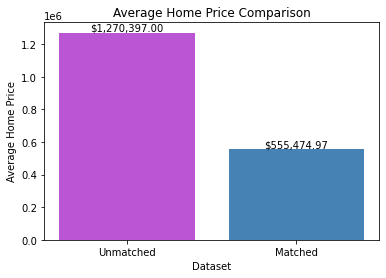

In [214]:
average_home_price_matched = df_matched['2020'].mean()
average_home_price_unmatched = df_unmatched['2020'].mean()

labels = ['Unmatched', 'Matched']
values = [average_home_price_unmatched, average_home_price_matched]

colors = ['mediumorchid','steelblue']

sns.set_palette(colors)

plt.bar(labels, values, color=colors)

for i, v in enumerate(values):
    plt.text(i, v, str('${:,.2f}'.format(v)), ha='center', va='bottom')

plt.xlabel('Dataset')
plt.ylabel('Average Home Price')
plt.title('Average Home Price Comparison')

plt.show()


In [ ]:
df_unmatched.head(2) 

In [217]:

# Naive bayes analysis

df_matched = df_matched.drop(["City / Community", "Occupation","Affordability Based on 3x Salary"], axis=1)
df_unmatched = df_unmatched.drop(["City / Community", "Occupation","Affordability Based on 3x Salary"], axis=1)

# combine the matched and unmatched datasets and create labels
df_matched['Label'] = 1  #   1 to df_matched
df_unmatched['Label'] = 2  # 2 to df_unmatched
combined_data = pd.concat([df_matched, df_unmatched], ignore_index=True)

# split the combined data into features (X) and labels (y)
X = combined_data.drop('Label', axis=1)
y = combined_data['Label']

classifier = GaussianNB()
classifier.fit(X, y)
predictions = classifier.predict(X)
accuracy = accuracy_score(y, predictions)

df_matched_predictions = predictions[combined_data['Label'] == 1]
df_unmatched_predictions = predictions[combined_data['Label'] == 2]

print("Accuracy:", accuracy)
print("df_matched Predictions:", df_matched_predictions)
print("df_unmatched Predictions:", df_unmatched_predictions)


Accuracy: 0.9483870967741935
df_matched Predictions: [2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 1 2 1 2 2]
df_unmatched Predictions: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


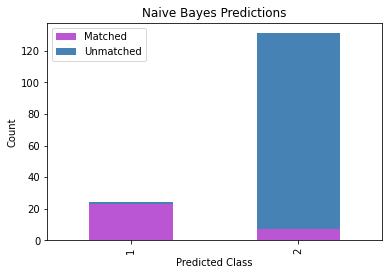

In [218]:

df_matched_predictions = pd.Series(df_matched_predictions)
df_unmatched_predictions = pd.Series(df_unmatched_predictions)

matched_counts = df_matched_predictions.value_counts()
unmatched_counts = df_unmatched_predictions.value_counts()

predictions_counts = pd.DataFrame({'Matched': matched_counts, 'Unmatched': unmatched_counts})

predictions_counts.plot(kind='bar', stacked=True)
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('Naive Bayes Predictions')
plt.legend()
plt.show()


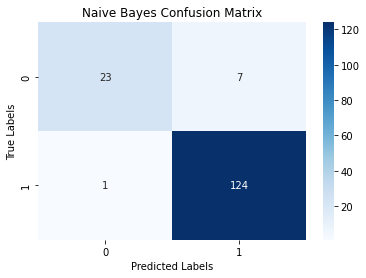

In [220]:

conf_matrix = confusion_matrix(y, predictions)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Add labels, title, and axis ticks
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Naive Bayes Confusion Matrix')

plt.show()


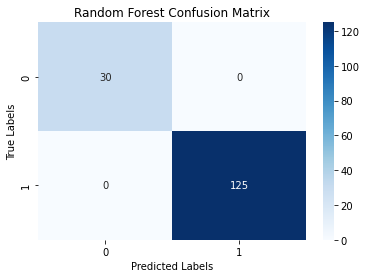

Accuracy: 1.0


In [221]:

#df_matched = df_matched.drop(["City / Community", "Occupation","Affordability Based on 3x Salary"], axis=1)
#df_unmatched = df_unmatched.drop(["City / Community", "Occupation","Affordability Based on 3x Salary"], axis=1)

# combine the matched and unmatched datasets and create labels
df_matched['Label'] = 1  #   1 to df_matched
df_unmatched['Label'] = 2  # 2 to df_unmatched
combined_data = pd.concat([df_matched, df_unmatched], ignore_index=True)

# split the combined data into features (X) and labels (y)
X = combined_data.drop('Label', axis=1)
y = combined_data['Label']

classifier = RandomForestClassifier()
classifier.fit(X, y)
predictions = classifier.predict(X)

conf_matrix = confusion_matrix(y, predictions)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Random Forest Confusion Matrix')

plt.show()
accuracy = accuracy_score(y, predictions)
print("Accuracy:", accuracy)

In [222]:

weapon_unmatched = df_unmatched['Total_Weapons'].values
crime_unmatched = df_unmatched['Total_Crimes'].values

weapon_matched = df_matched['Total_Weapons'].values
crime_matched = df_matched['Total_Crimes'].values

mean_weapon_unmatched = np.mean(weapon_unmatched)
std_weapon_unmatched = np.std(weapon_unmatched)
mean_crime_unmatched = np.mean(crime_unmatched)
std_crime_unmatched = np.std(crime_unmatched)

mean_weapon_matched = np.mean(weapon_matched)
std_weapon_matched = np.std(weapon_matched)
mean_crime_matched = np.mean(crime_matched)
std_crime_matched = np.std(crime_matched)

print("Unmatched Dataset:")
print("Mean Weapons:", mean_weapon_unmatched)
print("Standard Deviation Weapons:", std_weapon_unmatched)
print("Mean Crimes:", mean_crime_unmatched)
print("Standard Deviation Crimes:", std_crime_unmatched)

print("\nMatched Dataset:")
print("Mean Weapons:", mean_weapon_matched)
print("Standard Deviation Weapons:", std_weapon_matched)
print("Mean Crimes:", mean_crime_matched)
print("Standard Deviation Crimes:", std_crime_matched)


Unmatched Dataset:
Mean Weapons: 1310.16
Standard Deviation Weapons: 1373.1998042528262
Mean Crimes: 4132.392
Standard Deviation Crimes: 3723.4927214023123

Matched Dataset:
Mean Weapons: 2496.4333333333334
Standard Deviation Weapons: 2578.919653438022
Mean Crimes: 5651.233333333334
Standard Deviation Crimes: 5425.104623773526


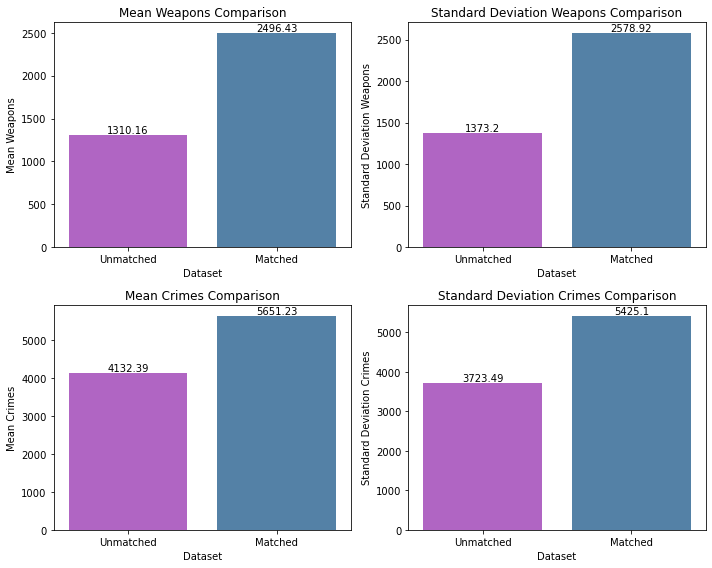

In [223]:
# plot descriptive statistics
weapon_labels = ['Unmatched', 'Matched']
mean_weapons = [mean_weapon_unmatched, mean_weapon_matched]
std_weapons = [std_weapon_unmatched, std_weapon_matched]

crime_labels = ['Unmatched', 'Matched']
mean_crimes = [mean_crime_unmatched, mean_crime_matched]
std_crimes = [std_crime_unmatched, std_crime_matched]

colors = ['mediumorchid', 'steelblue']

sns.set_palette(colors)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

sns.barplot(x=weapon_labels, y=mean_weapons, ax=axs[0, 0])
axs[0, 0].set_xlabel('Dataset')
axs[0, 0].set_ylabel('Mean Weapons')
axs[0, 0].set_title('Mean Weapons Comparison')
axs[0, 0].set_xticklabels(weapon_labels)  # Set x-axis tick labels

for i, v in enumerate(mean_weapons):
    axs[0, 0].annotate(str(round(v, 2)), (i, v), ha='center', va='bottom')

sns.barplot(x=weapon_labels, y=std_weapons, ax=axs[0, 1])
axs[0, 1].set_xlabel('Dataset')
axs[0, 1].set_ylabel('Standard Deviation Weapons')
axs[0, 1].set_title('Standard Deviation Weapons Comparison')
axs[0, 1].set_xticklabels(weapon_labels)  # Set x-axis tick labels

for i, v in enumerate(std_weapons):
    axs[0, 1].annotate(str(round(v, 2)), (i, v), ha='center', va='bottom')

sns.barplot(x=crime_labels, y=mean_crimes, ax=axs[1, 0])
axs[1, 0].set_xlabel('Dataset')
axs[1, 0].set_ylabel('Mean Crimes')
axs[1, 0].set_title('Mean Crimes Comparison')
axs[1, 0].set_xticklabels(crime_labels)  # Set x-axis tick labels

for i, v in enumerate(mean_crimes):
    axs[1, 0].annotate(str(round(v, 2)), (i, v), ha='center', va='bottom')

sns.barplot(x=crime_labels, y=std_crimes, ax=axs[1, 1])
axs[1, 1].set_xlabel('Dataset')
axs[1, 1].set_ylabel('Standard Deviation Crimes')
axs[1, 1].set_title('Standard Deviation Crimes Comparison')
axs[1, 1].set_xticklabels(crime_labels)  # Set x-axis tick labels

for i, v in enumerate(std_crimes):
    axs[1, 1].annotate(str(round(v, 2)), (i, v), ha='center', va='bottom')

plt.tight_layout()

plt.show()
